# SikinCancer medical diagnosis with transfer learning


*   author: Jafet Israel Sierra Lagos
*   contact: jafet.sierra.l@gmail.com




In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jul 12 00:02:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

conect to drive to get the train and test data

In [ ]:
#First conect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install keras tuner via pip package

In [ ]:
! pip install keras-tuner -q

     |████████████████████████████████| 133 kB 5.0 MB/s 


unzip the dataset

In [ ]:
! unzip '/content/drive/MyDrive/Proyectos/SkinCancer/data.zip'

Libraries

In [ ]:
#Importamos todas las librerias y paquetes necesarios
import os
import csv
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, InputLayer, Flatten, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from tensorflow import keras

from tensorflow.keras.utils import image_dataset_from_directory

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.optimizers import Adadelta, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import L2
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

### Ordenamiento de datos y creacion de subcarpetas por cada clase

In [ ]:
#Meta data and file index with images ids and diagnosis 
#Archivo con los id's de cada imagen y el diagnostico 
df = pd.read_csv('/content/drive/MyDrive/Proyectos/SkinCancer/HAM10000_metadata.csv')
df.head()

In [ ]:
#Prueba para saber si el ordenamiento en clases resulto bien
df.loc[df['image_id']=='ISIC_0024312']

,lesion_id,image_id,dx,dx_type,age,sex,localization
700,HAM_0001359,ISIC_0024312,bkl,histo,75.0,male,lower extremity


#### **The types of diagnosis can be seen below:  \Los tipos de diagnostico se pueden ver abajo**

*   0: akiec,
*   1: bcc,
*   2: bkl, 
*   3: dermatofibroma (df),
*   4: melanoma (mel),
*   5: melanocytic nevi (nv),
*   6: vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc)


In [ ]:
img_list = list(df['image_id'])
len(img_list)

10015

In [ ]:
df['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [ ]:
df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

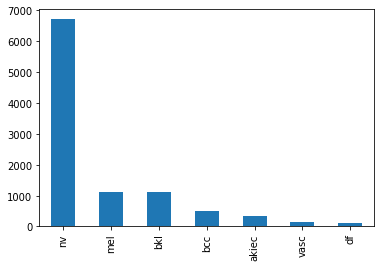

In [ ]:
df['dx'].value_counts().plot(kind='bar')

Besides that, in this case i'll separate my data into two classes. Melanoma and non_melanoma

I used split-folders to create a train validation test split with stratified sampling from the original dataset

### ImageDataGenerator

In [ ]:
IMG_SIZE = (224,224)
def get_ImageDataGenerator(path,subset=None,batch_size=32,seed=123,shuffle=True):
  return image_dataset_from_directory(
      path,
      image_size=IMG_SIZE,
      batch_size=batch_size,
      shuffle=shuffle,
      labels='inferred',
      label_mode='categorical',
      seed=seed,
      subset=subset
  )
'''
#preprocessing_function=preprocess_input,
      brightness_range=(0.3,1),
      zoom_range=0.2,
'''

'\n#preprocessing_function=preprocess_input,\n      brightness_range=(0.3,1),\n      zoom_range=0.2,\n'

#### train/val/test

In [ ]:
my_directory = '/content/data'
batch = 32

train_ds = get_ImageDataGenerator(my_directory+'/train')
val_ds   = get_ImageDataGenerator(my_directory+'/val')
test_ds  = get_ImageDataGenerator(my_directory+'/test',batch_size=1,shuffle=False)

Found 14242 files belonging to 2 classes.
Found 1780 files belonging to 2 classes.
Found 1782 files belonging to 2 classes.


num of classes and its labels

In [ ]:
class_names = train_ds.class_names
num_class   = len(class_names)
print(class_names)

['benign', 'malignan_aug']


some of the images on the train dataset

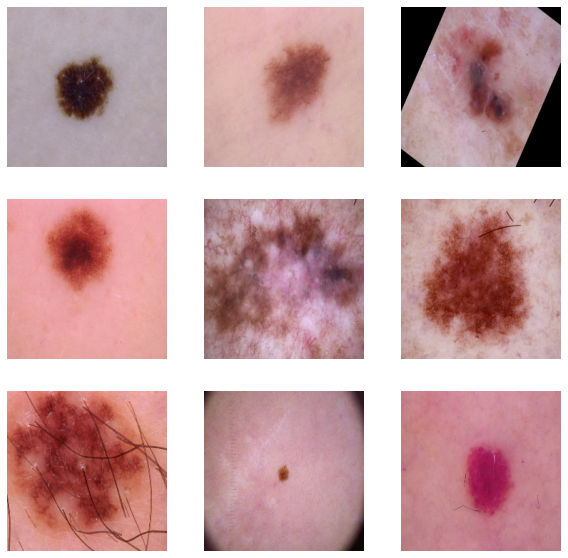

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

### Data augmentation

#### rotation, flip and zoom

In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
data_aug = Sequential([
    #RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.1)
])

shape of the images

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 2)


### Base model

Preprocess function from VGG19
We import and use the preprocess_input that was used in the training of ResNet50V2 model as a new Keras layer

In [ ]:
preprocess_layer = preprocess_input

VGG19 model trained with Imagenet dataset without the top layers.

In [ ]:
IMG_SHAPE = IMG_SIZE+(3,)
base_model = VGG19(
  input_shape=(IMG_SHAPE),
  include_top=False,
  weights='imagenet'
)

80150528/80134624 [==============================] - 0s 0us/step


Freeze the layers of the base model

In [ ]:
base_model.trainable = False
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## keras_tuner

Search for the best hyperparameters and model architecture

In [ ]:
'''
  for i in range(hp.Int("num_conv2d",1,3)):
    x = Conv2D(
        filters=hp.Int(f"units_{i}",min_value=10,max_value=40,step=10),
        kernel_size=hp.Int(f"kernel_{i}",min_value=2,max_value=4,step=1),
    )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
  '''

def build_model(hp):
  inputs = Input(shape=(224,224,3))
  x      = data_aug(inputs)
  x      = preprocess_layer(x)
  x      = base_model(x,training=False)
  x = GlobalAveragePooling2D()(x)
  for i in range(hp.Int("num_dense_layers",1,3)):
    x = Dense(
            units=hp.Int(f"units_{i}",min_value=64,max_value=512,step=64),
            kernel_regularizer='l2',
            kernel_initializer='he_normal',
            bias_initializer='zeros'
        )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(hp.Float(f"dpr_{i}",min_value=0.2,max_value=0.3,step=0.1))(x)
  out = Dense(num_class,activation='softmax')(x)

  #Learning rate search
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-3, sampling="log")
  
  #we define the model
  model = Model(inputs=inputs,outputs=out)

  #compile the model
  metricas = [
            tf.keras.metrics.CategoricalAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
  ]

  model.compile(
    optimizer=Adam(learning_rate),
    loss='categorical_crossentropy',
    metrics=metricas
  )

  return model

Callback for learning rate scheduler and BayesianOptimization search for best hyperpameters

In [ ]:
def scheduler(epoch,lr):
  if epoch<5:
    return lr
  else:
    return lr*tf.math.exp(-0.105)

tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_categorical_accuracy",
    max_trials=25,
    executions_per_trial=2,
    overwrite=True,
    directory="/content/keras_tuner",
    project_name="skin_cancer_tuner"
)
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sampling': None}
dpr_0 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.001, 'step': None, 'sampling': 'log'}


Search

In [ ]:
tuner.search(train_ds, epochs=2,validation_data=val_ds,callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler)])

Trial 25 Complete [00h 06m 55s]
val_categorical_accuracy: 0.8943819999694824

Best val_categorical_accuracy So Far: 0.8943819999694824
Total elapsed time: 02h 57m 02s
INFO:tensorflow:Oracle triggered exit


summary

In [ ]:
tuner.results_summary()

Results summary
Results in /content/keras_tuner/skin_cancer_tuner
Showing 10 best trials
Trial summary
Hyperparameters:
num_dense_layers: 2
units_0: 384
dpr_0: 0.2
lr: 0.0002261164975187842
units_1: 384
dpr_1: 0.30000000000000004
units_2: 256
dpr_2: 0.2
Score: 0.8943819999694824
Trial summary
Hyperparameters:
num_dense_layers: 2
units_0: 512
dpr_0: 0.2
lr: 0.00023853060371053868
units_1: 448
dpr_1: 0.30000000000000004
units_2: 320
dpr_2: 0.2
Score: 0.893539309501648
Trial summary
Hyperparameters:
num_dense_layers: 2
units_0: 448
dpr_0: 0.2
lr: 0.0003418470664624005
units_1: 384
dpr_1: 0.30000000000000004
units_2: 320
dpr_2: 0.2
Score: 0.8890449702739716
Trial summary
Hyperparameters:
num_dense_layers: 2
units_0: 512
dpr_0: 0.2
lr: 0.00017811965188774644
units_1: 320
dpr_1: 0.30000000000000004
units_2: 256
dpr_2: 0.2
Score: 0.8884831368923187
Trial summary
Hyperparameters:
num_dense_layers: 2
units_0: 448
dpr_0: 0.2
lr: 0.0003336781280282557
units_1: 512
dpr_1: 0.30000000000000004
units

Best so far

In [ ]:
best_hps = tuner.get_best_hyperparameters(5) 
model = build_model(best_hps[0])

Best model architecture summary

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1   (None, 512)              0   

## Best model training

In [ ]:
def build_best_model():
  inputs = Input(shape=(224,224,3))
  x      = data_aug(inputs)
  x      = preprocess_layer(x)
  x      = base_model(x,training=False)
  x      = GlobalAveragePooling2D()(x)
  x      = Dense(384,kernel_regularizer='l2',
            kernel_initializer='he_normal',
            bias_initializer='zeros')(x)
  x      = BatchNormalization()(x)
  x      = Activation('relu')(x)
  x      = Dropout(0.3)(x)
  x      = Dense(384,kernel_regularizer='l2',
            kernel_initializer='he_normal',
            bias_initializer='zeros')(x)
  x      = BatchNormalization()(x)
  x      = Activation('relu')(x)
  x      = Dropout(0.3)(x)
  out    = Dense(num_class,activation='softmax')(x)

  #Learning rate search
  learning_rate = 2.3e-4
  
  #we define the model
  model = Model(inputs=inputs,outputs=out)

  #compile the model
  metricas = [
            tf.keras.metrics.CategoricalAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
  ]

  model.compile(
    optimizer=Adam(learning_rate),
    loss='categorical_crossentropy',
    metrics=metricas
  )

  return model

In [ ]:
best_model = build_best_model()
best_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_2   (None, 512)              0   

callbacks and training function

In [ ]:
def scheduler(epoch,lr):
  if epoch<1:
    return lr
  else:
    return lr*tf.math.exp(-0.1)

def checkpoint_best():
  path = 'checkpoint_best/checkpoint'
  checkp = ModelCheckpoint(
      filepath=path,
      save_weights_only=True,
      save_freq='epoch',
      monitor='val_categorical_accuracy',
      save_best_only=True,
      verbose=1
  )
  return checkp

def train_model_gen(model,train_gen,val_gen,epochs):
  early_stop = EarlyStopping(patience=1,monitor='val_categorical_accuracy')
  #reduce_lr  = ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,patience=2)

  return model.fit(
      train_gen,
      validation_data=val_gen,
      epochs=epochs,
      callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler),checkpoint_best()],
      verbose=1
)

### training loop

In [ ]:
history = train_model_gen(best_model,train_ds,val_ds,5)

Epoch 1/5
445/446 [============================>.] - ETA: 0s - loss: 9.1232 - categorical_accuracy: 0.8331 - precision_2: 0.8331 - recall_2: 0.8331
Epoch 1: val_categorical_accuracy improved from -inf to 0.88596, saving model to checkpoint_best/checkpoint
446/446 [==============================] - 105s 232ms/step - loss: 9.1226 - categorical_accuracy: 0.8332 - precision_2: 0.8332 - recall_2: 0.8332 - val_loss: 4.7280 - val_categorical_accuracy: 0.8860 - val_precision_2: 0.8860 - val_recall_2: 0.8860 - lr: 2.3000e-04
Epoch 2/5
445/446 [============================>.] - ETA: 0s - loss: 3.2035 - categorical_accuracy: 0.8600 - precision_2: 0.8600 - recall_2: 0.8600
Epoch 2: val_categorical_accuracy improved from 0.88596 to 0.89157, saving model to checkpoint_best/checkpoint
446/446 [==============================] - 103s 230ms/step - loss: 3.2036 - categorical_accuracy: 0.8599 - precision_2: 0.8599 - recall_2: 0.8599 - val_loss: 2.0542 - val_categorical_accuracy: 0.8916 - val_precision_2: 

In [ ]:
best_model.load_weights('/content/checkpoint_best/checkpoint')

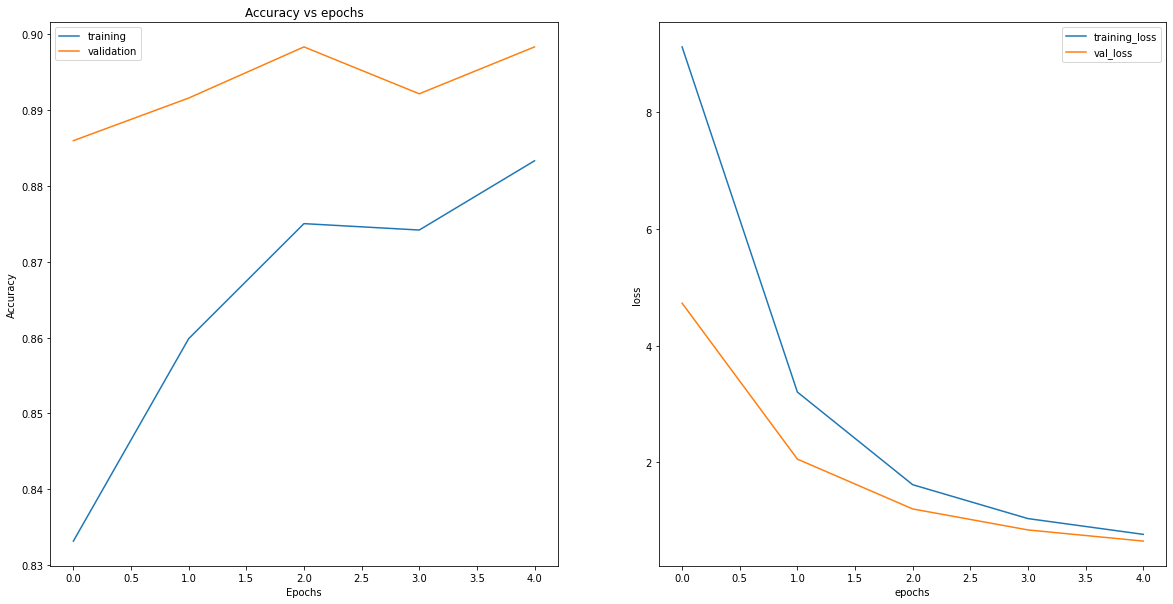

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(121)
try:
  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
except KeyError:
  plt.plot(history.history['acc_categorical_'])
  plt.plot(history.history['val_categorical_acc'])
plt.title('Accuracy vs epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'])
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['training_loss','val_loss'])
plt.show()

## Fine Tunning section

total number of layers from the base model

In [ ]:
print("Number of layers: ", len(base_model.layers))

Number of layers:  22


we select the point o layer where start to unfreeze

In [ ]:
base_model.trainable =True
fine_tune_at = 20
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

metrics and model compile with some of the base model layers unfreezed

In [ ]:
early_stop = EarlyStopping(patience=1,monitor='val_categorical_accuracy')
fine_metric = [
            tf.keras.metrics.CategoricalAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall()
  ]
best_model.compile(
    loss='categorical_crossentropy',
    metrics=fine_metric,
    optimizer = Adam(2e-5)
)

best_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_2   (None, 512)              0   

callbacks and training function

In [ ]:
def checkpoint_best_ft():
  path = 'checkpoint_best_ft/checkpoint'
  checkp = ModelCheckpoint(
      filepath=path,
      save_weights_only=True,
      save_freq='epoch',
      monitor='val_categorical_accuracy',
      save_best_only=True,
      verbose=1
  )
  return checkp
def fine_scheduler(epoch,lr):
  if epoch<1:
    return lr
  else:
    return lr*tf.math.exp(-0.1)

ini_epochs = len(history.epoch)
fine_tun_epochs = 5
total_epochs = ini_epochs + fine_tun_epochs


def train_model_fine_tuning(model,train_gen,val_gen,total_epochs,ini_epoch):
  early_stop = EarlyStopping(patience=1,monitor='val_categorical_accuracy')
  #reduce_lr  = ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,patience=2)
  return model.fit(
      train_ds,
      validation_data=val_ds,
      initial_epoch=ini_epoch,
      epochs=total_epochs,
      callbacks=[tf.keras.callbacks.LearningRateScheduler(fine_scheduler),checkpoint_best_ft(),early_stop],
      verbose=1
)

fine tuning training loop

In [ ]:
fine_history = train_model_fine_tuning(best_model,train_ds,val_ds,total_epochs,ini_epochs)

Epoch 6/10
446/446 [==============================] - ETA: 0s - loss: 0.6520 - categorical_accuracy: 0.8924 - precision_3: 0.8924 - recall_3: 0.8924
Epoch 6: val_categorical_accuracy improved from -inf to 0.90618, saving model to checkpoint_best_ft/checkpoint
446/446 [==============================] - 109s 237ms/step - loss: 0.6520 - categorical_accuracy: 0.8924 - precision_3: 0.8924 - recall_3: 0.8924 - val_loss: 0.6144 - val_categorical_accuracy: 0.9062 - val_precision_3: 0.9062 - val_recall_3: 0.9062 - lr: 1.8097e-05
Epoch 7/10
445/446 [============================>.] - ETA: 0s - loss: 0.6153 - categorical_accuracy: 0.8987 - precision_3: 0.8987 - recall_3: 0.8987
Epoch 7: val_categorical_accuracy did not improve from 0.90618
446/446 [==============================] - 104s 233ms/step - loss: 0.6157 - categorical_accuracy: 0.8986 - precision_3: 0.8986 - recall_3: 0.8986 - val_loss: 0.6049 - val_categorical_accuracy: 0.9017 - val_precision_3: 0.9017 - val_recall_3: 0.9017 - lr: 1.6375e

In [ ]:
cat_acc     = [*history.history['categorical_accuracy'],*fine_history.history['categorical_accuracy']]
val_cat_acc = [*history.history['val_categorical_accuracy'],*fine_history.history['val_categorical_accuracy']]
loss_       = [*history.history['loss'],*fine_history.history['loss']]
val_loss    = [*history.history['val_loss'],*fine_history.history['val_loss']]

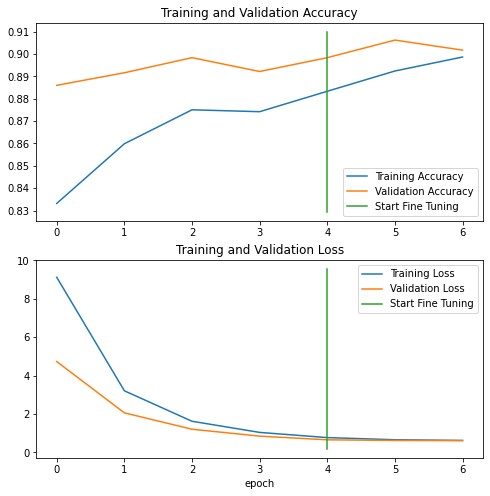

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(cat_acc, label='Training Accuracy')
plt.plot(val_cat_acc, label='Validation Accuracy')
plt.plot([ini_epochs-1,ini_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([ini_epochs-1,ini_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Model Evaluation on Test set

In [ ]:
## loading best weights 
best_model.load_weights('/content/checkpoint_best_ft/checkpoint')

In [ ]:
version = '003'
tf.saved_model.save(best_model,f'/content/drive/MyDrive/Proyectos/SkinCancer/model_v_{version}')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Proyectos/SkinCancer/model_v_003/assets


performance on the test dataset

In [ ]:
files = 1782

labels = []
for i in test_ds.take(files):
  labels.append(i[1][0].numpy())


predictions = best_model.predict(test_ds,steps=1782)
y_pred      = [np.argmax(x) for x in predictions]
y_true      = [np.argmax(y) for y in labels]

F1-score

In [ ]:
f1_score(y_true,y_pred)

0.8821822402785839

confussion matrix

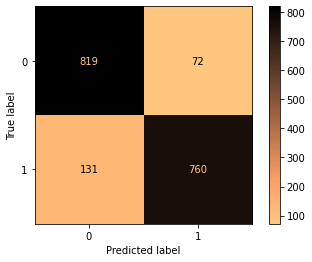

In [ ]:
cm   = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='copper_r')
plt.show()

In [ ]:
new_model.save('/content/drive/MyDrive/Proyectos/SkinCancer/SkinCancer_model_v5.h5')

#model.load_weights('/content/drive/MyDrive/Introduction_tensorflow_week_5_assignment/checkpoint_best/checkpoint')
#get_test_accuracy(model, test_data_gray, test_targets)

### predict for a single image and printing the filters for some layers

In [ ]:
import keras.backend as K
from keras.preprocessing.image import img_to_array

In [ ]:
def load_img(path):
  img = tf.keras.utils.load_img(path,target_size=(224,224,3))
  img = img_to_array(img)
  img = np.expand_dims(img,0)
  #img = preprocess_input(img)
  #plt.imshow(img[0])
  return img
def predict_one(tensor):
  prediction = best_model.predict(tensor)
  return prediction


In [ ]:
sample = load_img('/content/ISIC_0024312.jpg')
best_model.predict(sample)

array([[0.9831208 , 0.01687922]], dtype=float32)

In [ ]:
func = K.function([best_model.layers[0].input],best_model.get_layer('vgg19').output)
final_conv_output = func(sample)
final_conv_output.shape

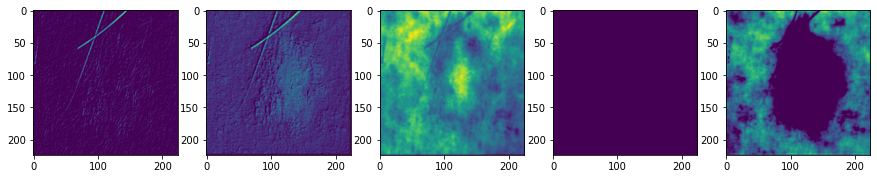

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(15,15))
j = 0
for i in range(final_conv_output.shape[-1]):
  if j<5:
    ax[i].imshow(final_conv_output[0,:,:,i])
  else:
    break
  j+=1
plt.show()

## TFlite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()
with open("tflite_model.tflite","wb") as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpdpa43q6u/assets


INFO:tensorflow:Assets written to: /tmp/tmpdpa43q6u/assets


## Aditional functions and code employed


In [ ]:
#this part is only for the procces of re-ordering the data in a local pc, dont run here

#Este fue el proceeso que hice para re-organizar todo el contenido en subcarpetas con cada clase, no ejecutar aqui
#pues las rutas no son iguales y dará un error.
#This part is just for grouping and dividing all the data into separate folders, one for each class
#Adding ".jpg" to all element in the column "image_id" 
df = pd.read_csv('HAM10000_metadata.csv')
df['image_id'] = df['image_id'].astype(str) + '.jpg'

#grouping all the data by dx type
gropued_df = df[['image_id','dx']].groupby(['dx'])
#Saving all the data into groups in a dictionary
types_dic = {}
for key,g in gropued_df:
  types_dic[key] = list(g['image_id'])

#storing the image's file location
files = os.listdir('HAM10000_images')

#Copying files into the new folders

for index,file in enumerate(files):
        keys = str([key for key,value in types_dic.items() if str(file) in value]).replace('[','').replace(']','').replace("'",'')
        shutil.copyfile(f'HAM10000_images/{file}','data/{}/{}'.format(keys,file))


In [ ]:
from IPython.core.pylabtools import figsize
epochs = [0,1,2]

fig, axs = plt.subplots(2,2,figsize=(15,15))
#-----------
subplot1 = 'val_accuracy'
for k, h in history_data.items():
  axs[0,0].plot(epochs,h[subplot1],label=k,linewidth=4.0)
  axs[0,0].text(epochs[-1],h[subplot1][-1],f'test: {k}')
axs[0,0].set_ylabel(subplot1)
axs[0,0].set_xlabel('Epochs')
axs[0,0].grid(True)
axs[0,0].legend()
axs[0,0].set_title(subplot1)

#-----------
subplot1 = 'accuracy'
for k, h in history_data.items():
  axs[0,1].plot(epochs,h[subplot1],label=k,linewidth=4.0)
  axs[0,1].text(epochs[-1],h[subplot1][-1],f'test: {k}')
axs[0,1].set_ylabel(subplot1)
axs[0,1].set_xlabel('Epochs')
axs[0,1].grid(True)
axs[0,1].legend()
axs[0,1].set_title(subplot1)

#-----------
subplot1 = 'loss'
for k, h in history_data.items():
  axs[1,1].plot(epochs,h[subplot1],label=k,linewidth=4.0)
  axs[1,1].text(epochs[-1],h[subplot1][-1],f'test: {k}')
axs[1,1].set_ylabel(subplot1)
axs[1,1].set_xlabel('Epochs')
axs[1,1].grid(True)
axs[1,1].legend()
axs[1,1].set_title(subplot1)

#-----------
subplot1 = 'val_loss'
for k, h in history_data.items():
  axs[1,0].plot(epochs,h[subplot1],label=k,linewidth=4.0)
  axs[1,0].text(epochs[-1],h[subplot1][-1],f'test: {k}')
axs[1,0].set_ylabel(subplot1)
axs[1,0].set_xlabel('Epochs')
axs[1,0].grid(True)
axs[1,0].legend()
axs[1,0].set_title(subplot1)